[Sven Kreiss](https://www.svenkreiss.com/), 2019

# Prediction API

Programmatically use OpenPifPaf to run multi-person pose estimation on an image.

In [1]:
%matplotlib inline

import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

device = torch.device('cpu')
# device = torch.device('cuda')  # if cuda is available

print(openpifpaf.__version__)
print(torch.__version__)

0.11.3
1.5.0


## Load an Example Image

Image credit: "[Learning to surf](https://www.flickr.com/photos/fotologic/6038911779/in/photostream/)" by fotologic which is licensed under [CC-BY-2.0].

[CC-BY-2.0]: https://creativecommons.org/licenses/by/2.0/

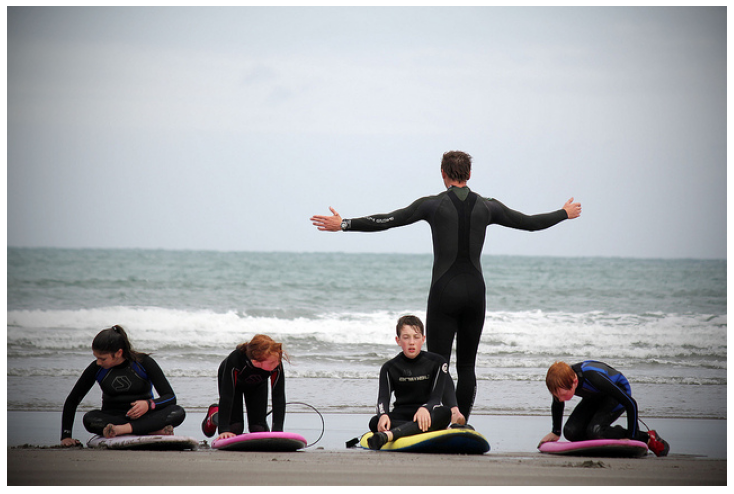

In [2]:
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

with openpifpaf.show.image_canvas(im) as ax:
  pass

## Load a Trained Neural Network

In [3]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='shufflenetv2k16w', download_progress=False)
net = net_cpu.to(device)

openpifpaf.decoder.CifSeeds.threshold = 0.5
openpifpaf.decoder.nms.Keypoints.keypoint_threshold = 0.2
openpifpaf.decoder.nms.Keypoints.instance_threshold = 0.2
processor = openpifpaf.decoder.factory_decode(net.head_nets, basenet_stride=net.base_net.stride)

## Dataset, Dataloader, Visualizer

In [4]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(
  data, batch_size=1, pin_memory=True, 
  collate_fn=openpifpaf.datasets.collate_images_anns_meta)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

## Prediction

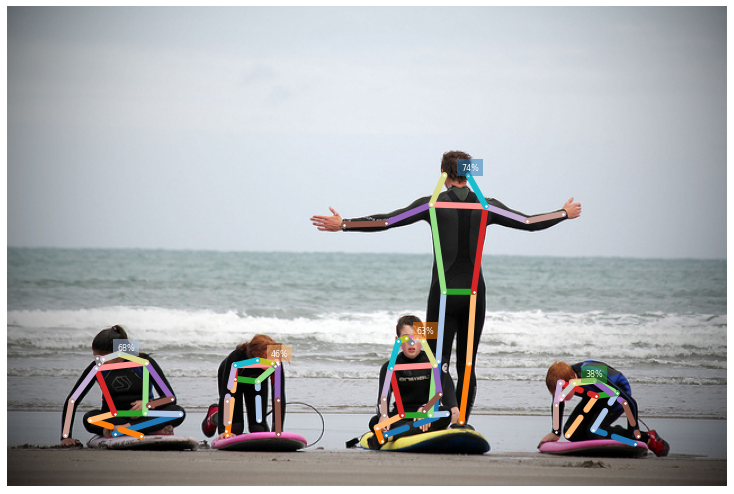

In [5]:
for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

## Fields

Below are visualizations of the fields.
When using the API here, the visualization types are individually enabled.
Then, the index for every field to visualize must be specified. In the example below, the fifth CIF (the left shoulder) and the fifth CAF (the left should to left hip association) are activated.

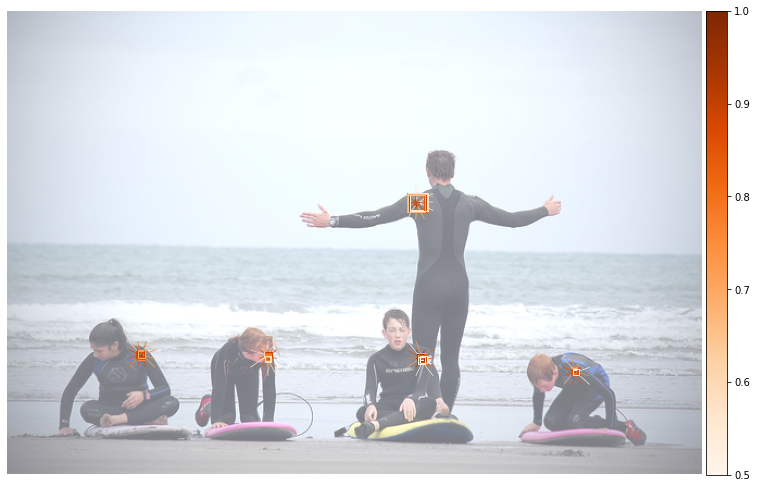

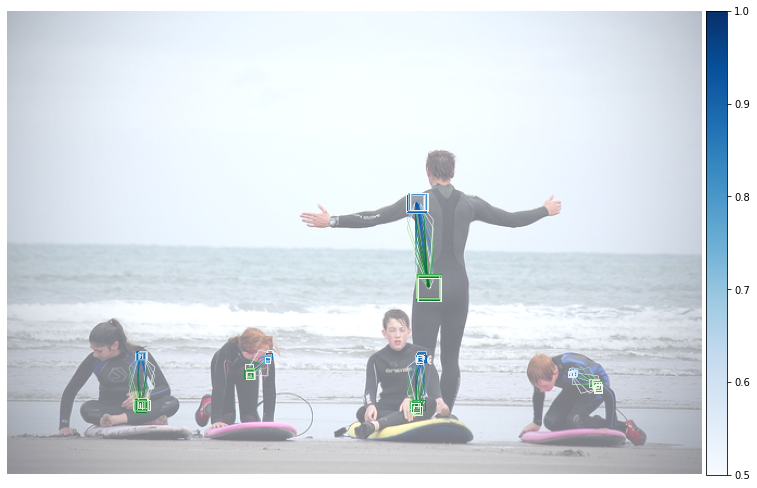

In [6]:
openpifpaf.visualizer.Cif.show_regressions = True
openpifpaf.visualizer.Caf.show_regressions = True
openpifpaf.visualizer.BaseVisualizer.all_indices = [('cif', 5), ('caf', 5)]

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]

In [7]:
# deactivate the previous outputs
openpifpaf.visualizer.Cif.show_regressions = False
openpifpaf.visualizer.Caf.show_regressions = False

From the CIF field, a high resolution accumulation (in the code it's called `CifHr`) is generated.
This is also the basis for the seeds. Both are shown below.

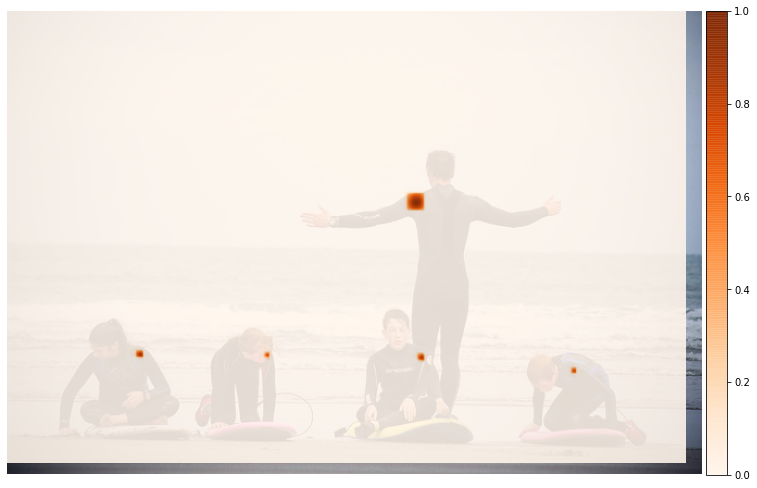

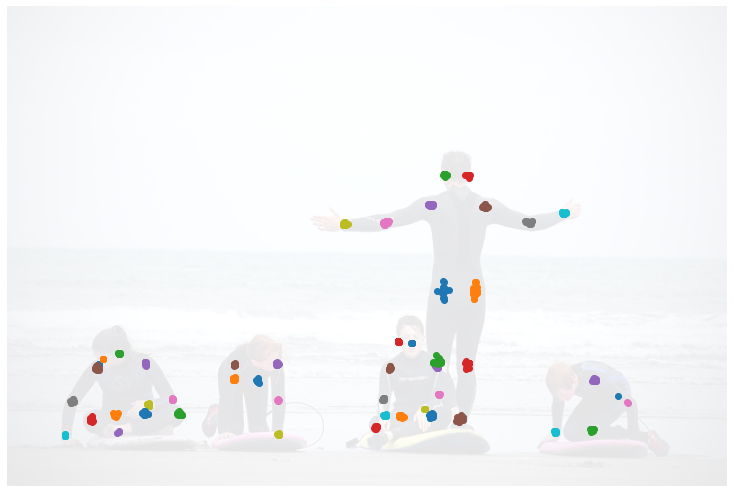

In [8]:
openpifpaf.visualizer.CifHr.show = True
openpifpaf.visualizer.Seeds.show = True
openpifpaf.visualizer.BaseVisualizer.all_indices = [('cif', 5), ('caf', 5)]

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]

In [ ]:
# deactivate previous outputs
openpifpaf.visualizer.CifHr.show = False
openpifpaf.visualizer.Seeds.show = False
